In [4]:
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
import skimage
import ImageD11
import xfab
import xfab.symmetry
import xfab.tools
from scipy.ndimage import median_filter, label, binary_fill_holes

from scipy.spatial.transform import Rotation

import ImageD11.grain
import ImageD11.cImageD11
import ImageD11.transform
import ImageD11.blobcorrector
import ImageD11.columnfile
import ImageD11.refinegrains
import ImageD11.sym_u

xfab.CHECKS.activated = False

plt.style.use('default')


In [5]:
path = os.path.join('/home/ax8427he/workspace/AL_DTU/data/','experiment','sam3','layer_center','sam3_pointscan_60N_fine_sparse.h5')
with h5py.File(path, "r") as f:
    print( f['1.1/'].keys() )
    

<KeysViewHDF5 ['col', 'frame', 'instrument', 'intensity', 'measurement', 'nnz', 'row']>


In [6]:
#Y    = np.load('X0_coord_gmap.npy')
#X    = np.load('Y0_coord_gmap.npy')
#gmap = np.load('gmap0.npy', allow_pickle=True)

gmap  = np.load('gmap.npy', allow_pickle=True)
X     = np.load('X_coord_gmap.npy')
Y     = np.load('Y_coord_gmap.npy')
refined_ubi_map = np.load('refined_ubi_map.npy', allow_pickle=True)


In [7]:
keys = ['layer_top', 'layer_center', 'layer_bottom']
idx = {'layer_top':2, 'layer_center':1, 'layer_bottom':0}
base = '/home/ax8427he/workspace/AL_DTU/data/experiment/sam3/'+keys[1]+'/'
!ls /home/ax8427he/workspace/AL_DTU/data/experiment/sam3/layer_bottom/*.h5
!ls /home/ax8427he/workspace/AL_DTU/data/experiment/sam3/layer_center/*.h5
!ls /home/ax8427he/workspace/AL_DTU/data/experiment/sam3/layer_top/*.h5

/home/ax8427he/workspace/AL_DTU/data/experiment/sam3/layer_bottom/sam3_pointscan_60N_fine_sparse_z0.h5
/home/ax8427he/workspace/AL_DTU/data/experiment/sam3/layer_center/sam3_pointscan_60N_fine_sparse.h5
/home/ax8427he/workspace/AL_DTU/data/experiment/sam3/layer_center/sam3_pointscan_60N_fine_sparse_z1.h5
/home/ax8427he/workspace/AL_DTU/data/experiment/sam3/layer_top/sam3_pointscan_60N_fine_sparse_z2.h5


In [8]:
key = keys[1]
pksfile = os.path.abspath( os.path.join( base,  'sam3_pointscan_60N_fine_sparse_z'+str(idx[key])+'.h5') )
parfile = os.path.abspath( os.path.join( base,  'aluS3.par') )
colf = ImageD11.columnfile.columnfile( pksfile )
colf.dty = 1e3 * ( colf.dty - np.min( colf.dty ) ) # now in microns
colf.dty = colf.dty - np.median(np.unique(colf.dty))
colf.parameters.loadparameters(parfile)
colf.updateGeometry()
ystep = 3
colf.addcolumn( np.round( colf.dty / ystep ).astype(int) , 'iy')
colf.iy -= np.min(colf.iy)

Reading your columnfile in hdf format


In [3]:
key = keys[1]
pksfile = os.path.abspath( os.path.join( base,  'sam3_pointscan_60N_fine_sparse_z'+str(idx[key])+'.h5') )
parfile = os.path.abspath( os.path.join( base,  'aluS3.par') )
colf = ImageD11.columnfile.columnfile( pksfile )
colf.dty = 1e3 * ( colf.dty - np.min( colf.dty ) ) # now in microns
colf.dty = colf.dty - np.median(np.unique(colf.dty))
colf.parameters.loadparameters(parfile)
colf.updateGeometry()
ystep = 3
colf.addcolumn( np.round( colf.dty / ystep ).astype(int) , 'iy')
colf.iy -= np.min(colf.iy)

NameError: name 'keys' is not defined

In [56]:
omstep = 1
sino = np.zeros( (180//omstep, np.max(colf.iy)+1) )
angles = np.array(range(0, 180, omstep))
for i,om in enumerate(angles):
    m = (colf.omega < om + omstep) & (colf.omega > om)
    np.add.at(sino[i,:], colf.iy[m], np.log(colf.sum_intensity[m]))
sino = sino / np.max(sino, axis=1).reshape(sino.shape[0], 1)
sino = sino.T

In [57]:
recon = skimage.transform.iradon( sino, angles).clip(0)
recon = np.repeat(recon, 2, axis=0)
recon = np.repeat(recon, 2, axis=1)

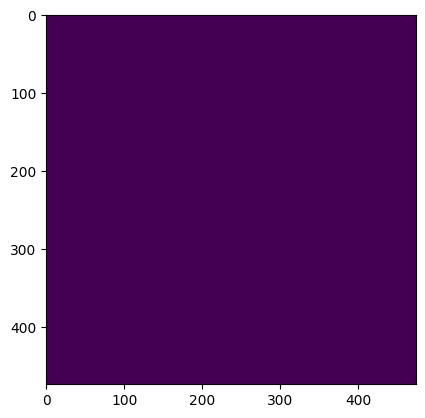

In [114]:
segmented_sample = recon > np.max(recon)*0.20
l, _ = label( segmented_sample.astype(int) )
lmax = np.argmax([np.sum(l==li) for li in np.unique(l) if li!=0])
segmented_sample = l==lmax+1
segmented_sample = binary_fill_holes(segmented_sample)
if 0: np.save('/home/ax8427he/workspace/AL_DTU/data/reconstructions/sam3/layer_center/test_run/sample_mask_layer_center.npy', segmented_sample.astype(bool))

#sample = np.load('/home/ax8427he/workspace/AL_DTU/data/reconstructions/sam3/layer_center/test_run/sample_mask_layer_center.npy')
#plt.imshow(sample*(~segmented_sample))

NameError: name 'colf' is not defined

In [140]:
(colf.dty.max()-colf.dty.min())//2

353.0

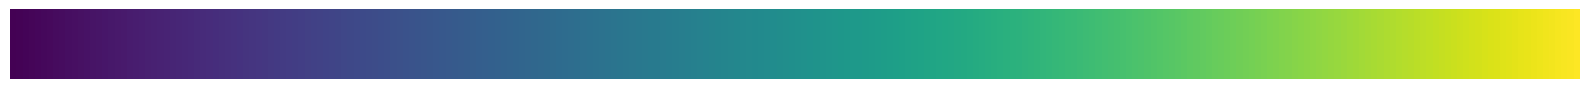

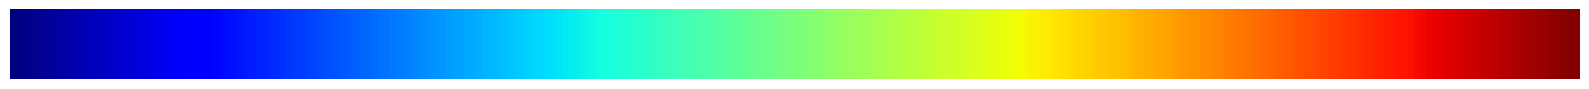

In [131]:
plt.figure(figsize=(16,1))
plt.imshow(np.linspace(0,100,2500).reshape(1,2500), aspect='auto', cmap='viridis')
plt.axis('off')
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,1))
plt.imshow(np.linspace(0,100,2500).reshape(1,2500), aspect='auto', cmap='jet')
plt.axis('off')
plt.tight_layout()
plt.show()

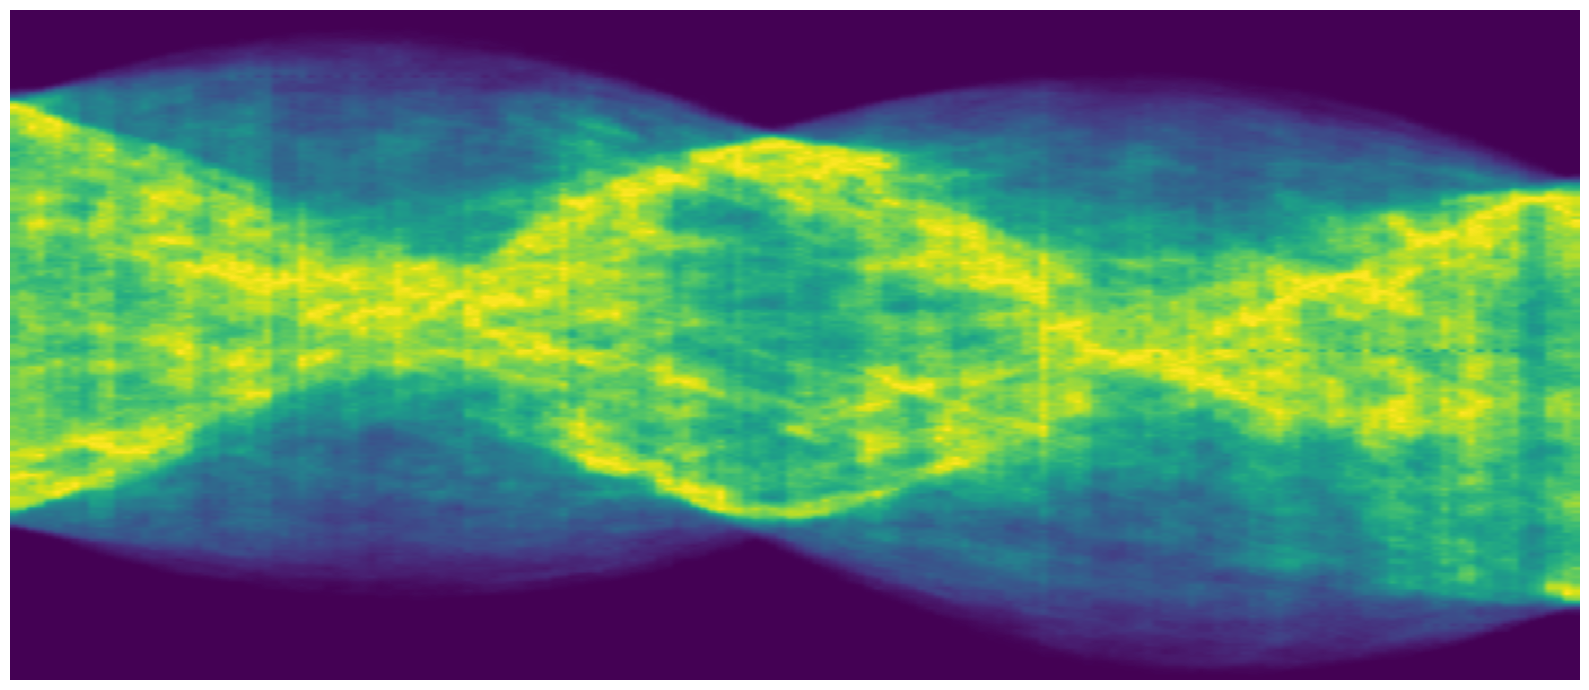

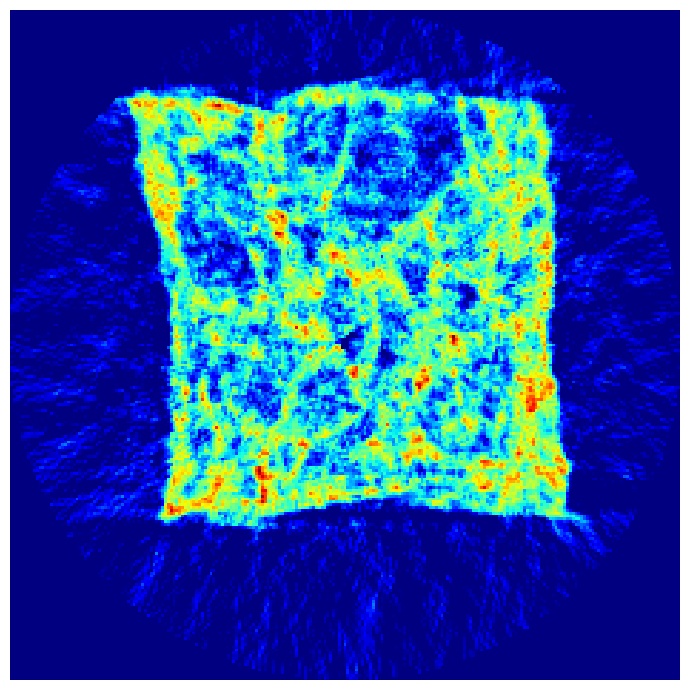

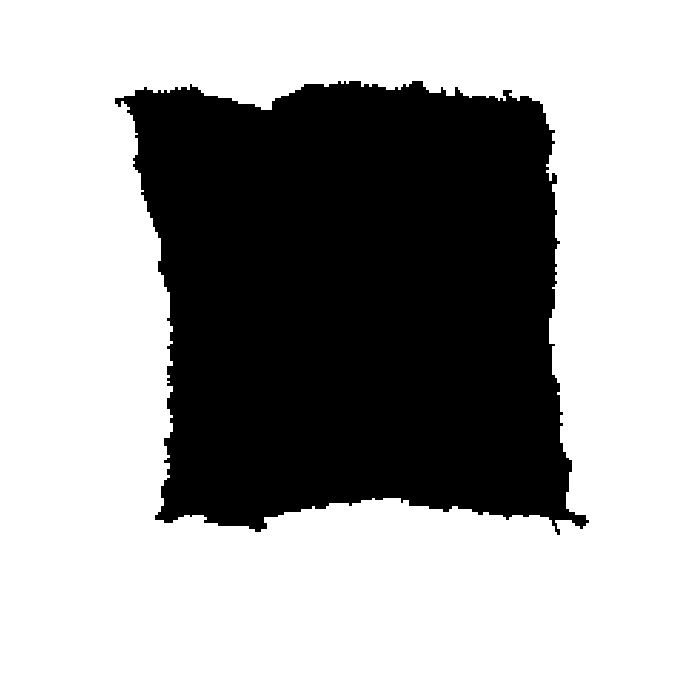

In [132]:
fig,ax = plt.subplots( 1, 1, figsize=(16,7) )
ax.imshow(sino, aspect='auto', cmap='viridis')
ax.axis('off')
plt.tight_layout()
fig.savefig('/home/ax8427he/workspace/AL_DTU/data/reconstructions/sam3/publication_figures/gallery/sample_sino.png', dpi=300)

fig,ax = plt.subplots( 1, 1, figsize=(7,7) )
ax.pcolormesh(X, Y, np.fliplr(recon[2:-2, 2:-2]), cmap='jet')
ax.axis('off')
plt.tight_layout()
fig.savefig('/home/ax8427he/workspace/AL_DTU/data/reconstructions/sam3/publication_figures/gallery/sample_recon.png', dpi=300)

fig,ax = plt.subplots( 1, 1, figsize=(7,7) )
ax.pcolormesh(X, Y, np.fliplr(segmented_sample[2:-2, 2:-2]), cmap='gray_r')
ax.axis('off')
plt.tight_layout()
fig.savefig('/home/ax8427he/workspace/AL_DTU/data/reconstructions/sam3/publication_figures/gallery/sample_mask.png', dpi=300)

plt.show()